# CRIPTOATAQUES

In [45]:
import sys
import os

project_root = "/workspaces/Criptoataques"

if project_root not in sys.path:
    sys.path.append(project_root)

## Análise Estatística dos Textos Originais

Antes de aplicar os algoritmos de criptografia, é fundamental entender as características estatísticas dos textos originais . Essa análise nos fornecerá uma base para comparar o impacto dos algoritmos nas propriedades dos dados.

### Métricas Estatísticas e Comparativos Iniciais

Nesta seção, serão apresentadas e comparadas as análises estatísticas para os textos de diferentes extensões..

In [46]:
import matplotlib.pyplot as plt

from crypto_io import ler_texto, inteiro_para_texto


from lib.ataques.cifra_de_Cesar import (
    ataque_cesar,
    cifrar,
)

from lib.ataques.analise_de_frequencia import (
    contar_frequencias,
    frequencia_relativa,
)

from lib.ataques.cifra_de_vigenere.vigenere import VigenereCifra

encriptar_decriptar = VigenereCifra.encriptar_decriptar


from lib.ataques.rsa_franklin_reiter import (
    ataque_franklin_reiter,
    gerador_caso_relacionado_linear,
)   

from lib.estatisticas import (
    medir_tempo,
    expansao_tamanho,
    calcular_avalanche,
    comparar_algoritmos,
    indice_coincidencia,
    tamanho_bytes,
)


base_path = "/workspaces/Criptoataques/examples/textos_base"
paths = {
    "Curto1": f"{base_path}/curto1.txt",
    # "Curto2": f"{base_path}/curto2.txt",
    # "Curto3": f"{base_path}/curto3.txt",
}

textos = {nome: ler_texto(caminho) for nome, caminho in paths.items()}

Segue bla bla

In [47]:
def plot_freq(texto, titulo):
    freqs = frequencia_relativa(contar_frequencias(texto))

    letras = list(freqs.keys())
    valores = list(freqs.values())

    plt.figure(figsize=(10, 4))
    plt.bar(letras, valores)
    plt.title(titulo)
    plt.xlabel("Caracteres")
    plt.ylabel("Frequência relativa")
    plt.show()


def plot_comparar_freq(textos_dict, titulo="Comparação de Frequências Relativas"):
    plt.figure(figsize=(12, 5))

    # Pegamos todas as letras possíveis
    todas_letras = sorted(
        set().union(*[contar_frequencias(t).keys() for t in textos_dict.values()])
    )

    for nome, texto in textos_dict.items():
        freq = frequencia_relativa(contar_frequencias(texto))

        valores = [freq.get(l, 0) for l in todas_letras]

        plt.plot(todas_letras, valores, label=nome)

    plt.title(titulo)
    plt.xlabel("Caracteres")
    plt.ylabel("Frequência relativa")
    plt.legend()
    plt.show()


def tabela_metricas(textos_dict):
    tabela = {}

    for nome, texto in textos_dict.items():
        freq_abs = contar_frequencias(texto)

        tabela[nome] = {
            "Índice de Coincidência": indice_coincidencia(texto),
            "Total de caracteres": len(texto),
            "Caracteres distintos": len(freq_abs)
        }

    return tabela

Segue uma tabela com as métricas dos textos:

In [48]:
metricas = tabela_metricas(textos)
metricas

{'Curto1': {'Índice de Coincidência': 0.04803635183382019,
  'Total de caracteres': 79,
  'Caracteres distintos': 17}}

bla bla bla

Segue os gráficos individuais de frequência:

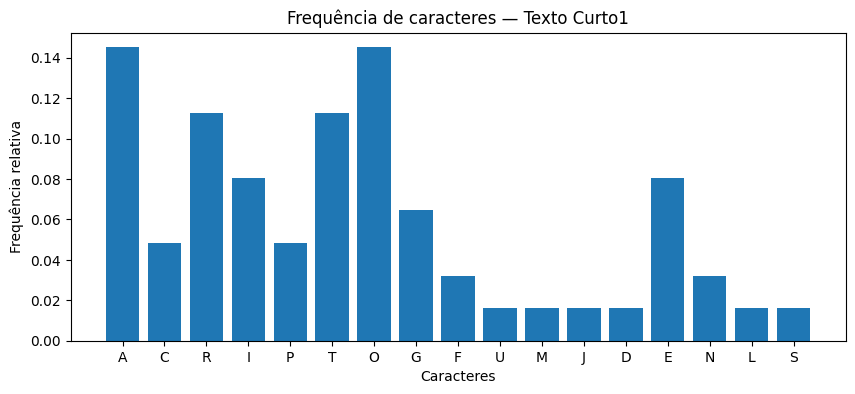

In [49]:
for nome, texto in textos.items():
    plot_freq(texto, f"Frequência de caracteres — Texto {nome}")

bla bla bla

Segue Gráfico comparativo dos três textos

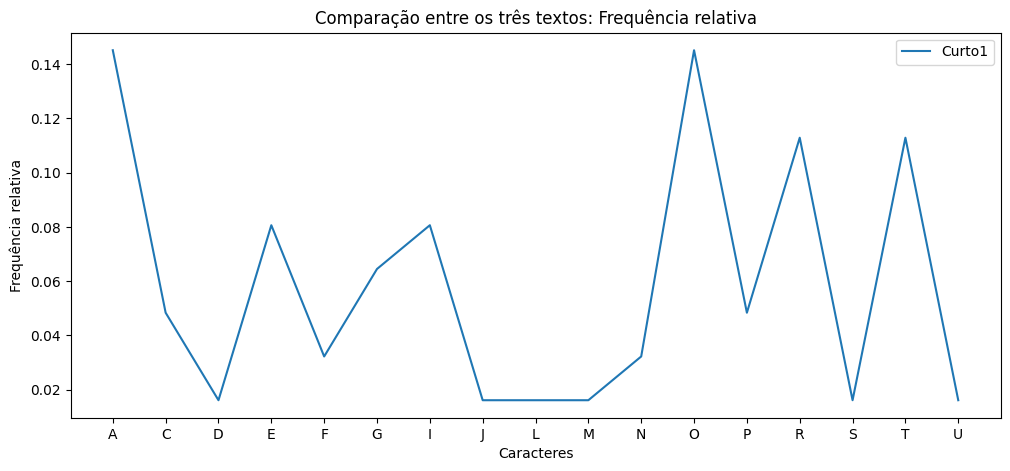

In [50]:
plot_comparar_freq(textos, "Comparação entre os três textos: Frequência relativa")

bla bla bla

## Análise de Desempenho dos Algoritmos Criptográficos

Para avaliar a eficácia e segurança dos algoritmos de criptografia, vamos analisar diversas métricas após a aplicação de cada algoritmo aos textos originais. Isso nos permitirá comparar o desempenho e as características dos textos cifrados e decifrados.

### Métricas de Avaliação Detalhadas e Comparativos

#### Tempo de Criptografia/Descriptografia

Esta métrica mede o tempo necessário para um algoritmo criptografar e descriptografar um determinado texto. É crucial para entender a eficiência operacional de cada algoritmo, especialmente em cenários de alta demanda ou com grandes volumes de dados. Um algoritmo mais rápido pode ser preferível, desde que não comprometa a segurança.

*   **Gráficos Comparativos:**

In [51]:
# def cesar_wrapper(texto):
#     return cifrar(texto, chave=3)

# def vigenere_cifrar(texto):
#     return encriptar_decriptar(texto, chave="criptografia", opcao="cifrar") 

# def vigenere_decifrar(texto_cifrado):
#     return encriptar_decriptar(texto_cifrado, chave="criptografia", opcao="decifrar")


# # Variável global para armazenar o 'caso' RSA por texto.
# # Chave: hash do texto original | Valor: o dicionário 'caso' completo.
# rsa_case_cache = {}
# MAX_RSA_BYTES = 250
# E_PARA_TESTE = 11
# BITS_PARA_TESTE = 512

# def rsa_cifrar(texto):
#     global rsa_case_cache
#     texto_limitado = texto[:MAX_RSA_BYTES]
    
#     if not texto_limitado:
#         raise ValueError("Texto de entrada vazio após limitação de tamanho.")
        
#     chave_cache = hash(texto_limitado)
    
#     if chave_cache not in rsa_case_cache:
#         caso = gerador_caso_relacionado_linear(
#             texto1=texto_limitado, 
#             bits=BITS_PARA_TESTE,
#             e_inicial=E_PARA_TESTE
#         )
#         rsa_case_cache[chave_cache] = caso
        
#     caso = rsa_case_cache[chave_cache]

#     return str(caso["c1"])


# def rsa_decifrar(texto_cifrado):
#     global rsa_case_cache
    
#     if not rsa_case_cache:
#         raise RuntimeError("Cache RSA vazio. Chame rsa_cifrar antes de rsa_decifrar.")
        
#     caso = list(rsa_case_cache.values())[0] 
    
#     ataque_franklin_reiter(
#         caso["c1"], caso["c2"], caso["e"], caso["n"], caso["a"], caso["b"], caso.get("nbytes")
#     )
#     return "Dummy" # mantém a interface de retorno

# # def rsa_cifrar(texto):
# #     # Limita o texto de entrada para que ele caiba no módulo N
# #     texto_limitado = texto[:250]
    
# #     if not texto_limitado:
# #         raise ValueError("Texto de entrada vazio após limitação de tamanho.")
        
# #     caso = gerador_caso_relacionado_linear(texto1=texto_limitado, bits=2048)
    
# #     # O ciphertext RSA é um inteiro, então transformamos em string
# #     return str(caso["c1"])

# # def rsa_decifrar(texto_cifrado):
# #     caso = gerador_caso_relacionado_linear(texto1="A" * 250, bits=2048) 
    
# #     ataque_franklin_reiter(
# #          caso["c1"], caso["c2"], caso["e"], caso["n"], caso["a"], caso["b"], caso.get("nbytes")
# #     )
# #     return "Dummy"

# algoritmos_dec = {
#     "César (dec)": lambda t: cifrar(t, chave=3),
#     "Vigenère (dec)": lambda t: encriptar_decriptar(t, chave="criptografia"),
#     "RSA (dec)": rsa_cifrar
# }

# algoritmos_combinados = {
#     "César": {
#         "cifrar": cesar_wrapper,
#         "decifrar": algoritmos_dec["César (dec)"],
#     },
#     #   "Vigenere": {
#     #     "cifrar": vigenere_cifrar,
#     #     "decifrar": vigenere_decifrar
#     # },
#     "RSA": {
#         "cifrar": rsa_cifrar,
#         "decifrar": rsa_decifrar,
#     },
# }

# comparacao = comparar_algoritmos(textos, algoritmos_combinados)

In [52]:
# def plot_tempo_cifra(comparacao):
#     """
#     Gera o gráfico de Tempo de Criptografia x Tamanho do Texto.
    
#     Args:
#         comparacao (dict): Dicionário aninhado de resultados.
#     """
#     plt.figure(figsize=(10, 6))
    
#     for nome_alg, resultados_alg in comparacao.items():
#         tamanhos = []
#         tempos_cifra = []
        
#         for dados_texto in resultados_alg.values():
#             tamanhos.append(dados_texto["tamanho"])
#             tempos_cifra.append(dados_texto["tempo_cifra"])
            
#         plt.plot(tamanhos, tempos_cifra, marker="o", label=nome_alg)

#     plt.title("Tempo de Criptografia x Tamanho do Texto")
#     plt.xlabel("Tamanho (bytes)")
#     plt.ylabel("Tempo (s)")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# plot_tempo_cifra(comparacao)

In [53]:
# def plot_tempo_decifra(comparacao):
#     """
#     Gera o gráfico de Tempo de Descriptografia x Tamanho do Texto.
    
#     Args:
#         comparacao (dict): Dicionário aninhado de resultados.
#     """
#     plt.figure(figsize=(10, 6))
    
#     for nome_alg, resultados_alg in comparacao.items():
#         tamanhos = []
#         tempos_decifra = []
        
#         # Itera sobre os resultados de cada texto
#         for dados_texto in resultados_alg.values():
#             tamanhos.append(dados_texto["tamanho"])
#             tempos_decifra.append(dados_texto["tempo_decifra"])

#         plt.plot(tamanhos, tempos_decifra, marker="s", label=nome_alg)

#     plt.title("Tempo de Descriptografia x Tamanho do Texto")
#     plt.xlabel("Tamanho (bytes)")
#     plt.ylabel("Tempo (s)")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# plot_tempo_decifra(comparacao)

*   **Análise Gráfica e de Resultados:**

    [Espaço para a análise textual das observações sobre o tempo de execução, comparando os algoritmos e o impacto do tamanho do texto.]

#### IC


*   **Teoria:** O Índice de Coincidência é uma ferramenta estatística utilizada para medir a probabilidade de que dois caracteres escolhidos aleatoriamente de um texto sejam iguais. Para textos em linguagem natural, o IC é relativamente alto. Após a criptografia, espera-se que o IC de um texto cifrado seja significativamente menor e próximo ao de um texto aleatório, indicando que a estrutura da linguagem original foi mascarada.

*   **Gráficos Comparativos:**

bla bla

#### Expansão de Tamanho

*   **Teoria:** Esta métrica avalia o quanto o tamanho do texto cifrado se expande em relação ao texto original. Alguns algoritmos criptográficos adicionam bytes extras (por exemplo, devido ao preenchimento - padding) ao texto original, resultando em um texto cifrado maior. A expansão excessiva pode ser um fator a considerar em aplicações com restrições de armazenamento ou largura de banda.

*   **Gráficos Comparativos:**

In [54]:
# def plot_comparativo_expansao(comparacao):
#     plt.figure(figsize=(8,5))
#     for alg, dados in comparacao.items():
#         plt.plot(dados["tamanho"], dados["expansao"], marker="o", label=alg)

#     plt.title("Expansão de Tamanho x Tamanho do Texto")
#     plt.xlabel("Tamanho (bytes)")
#     plt.ylabel("Expansão (%)")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


bla bla

#### Efeito Avalanche

*   **Teoria:** O efeito avalanche mede a propriedade de um algoritmo criptográfico onde uma pequena alteração no texto de entrada (ou na chave) resulta em uma grande alteração no texto de saída. Um bom efeito avalanche é essencial para a segurança, pois garante que mesmo pequenas modificações sejam propagadas extensivamente, dificultando a inferência de informações sobre o texto original ou a chave a partir do texto cifrado.

*   **Gráficos Comparativos:**

In [55]:
# def plot_avalanche(pares, label="Avalanche"):
#     valores = [calcular_avalanche(orig, mod) for orig, mod in pares]  # (texto, texto_modificado)

#     plt.figure(figsize=(8,5))
#     plt.plot(range(len(pares)), valores, marker="o")
#     plt.xlabel("Amostra")
#     plt.ylabel("Diferença (%)")
#     plt.title(label)
#     plt.grid(True)
#     plt.show()

# # pares = [(texto, texto_modificado), ...]
# # plot_avalanche(pares)

### Visualização: Textos Cifrados e Decifrados

## Cifra de César

## Análise de Frequência


## Cifra de Vigénere

In [56]:
vigenere = VigenereCifra()

In [57]:
# texto_original = open("examples/textos_base/longo.txt", encoding="utf-8").read()
# chave_encr = "raphaella"
# texto_cifrado = vigenere.encriptar_decriptar(texto_original, chave_encr, "ENCRIPTAR")
# print(texto_cifrado)

In [58]:
# vigenere.tamanho_chave(texto_cifrado)

In [59]:
# tamanho_chave = 9
# chave_encontrada = vigenere.quebra_chave(texto_cifrado,tamanho_chave, 'pt')
# print(chave_encontrada)

In [60]:
# texto_decriptado = vigenere.encriptar_decriptar(texto_cifrado, chave_encontrada,"DECRIPTAR")
# print(texto_decriptado)

## Criptografia RSA

In [61]:
# Funções RSA independentes para cada chamada

MAX_RSA_BYTES = 250
E_PARA_TESTE = 7
BITS_PARA_TESTE = 512

def rsa_cifrar_independente(texto):
    texto_limitado = texto[:MAX_RSA_BYTES]

    if not texto_limitado:
        raise ValueError("Texto de entrada vazio após limitação de tamanho.")

    # Gera um novo caso RSA para cada cifragem
    caso = gerador_caso_relacionado_linear(
        texto1=texto_limitado,
        bits=BITS_PARA_TESTE,
        e_inicial=E_PARA_TESTE
    )
    # Armazena o caso gerado na própria função para que a decifragem subsequente possa usá-lo
    rsa_cifrar_independente.last_case = caso

    return str(caso["c1"])

def rsa_decifrar_independente(texto_cifrado):

    if not hasattr(rsa_cifrar_independente, 'last_case'):
        raise RuntimeError("Erro: rsa_cifrar_independente não foi chamada. Não há caso RSA para decifrar.")

    caso = rsa_cifrar_independente.last_case

    cifrado = int(texto_cifrado)

    d = caso["d"]
    n = caso["n"]
    nbytes = caso["nbytes"]

    # decifra
    m = pow(cifrado, d, n)

    # converte para texto
    return inteiro_para_texto(m, nbytes)



In [62]:
# import pandas as pd
# import time

# # Função para medir tempo e capturar resultado
# def medir_tempo(func, *args, **kwargs):
#     start = time.time()
#     resultado = func(*args, **kwargs)
#     end = time.time()
#     return end - start, resultado

# # Dicionário para armazenar resultados
# rsa_tempos_ind = {}

# for nome, texto in textos.items():
#     print(f"Processando texto: {nome}")

#     # Medir tempo de cifragem
#     tempo_cifra, cifrado = medir_tempo(rsa_cifrar_independente, texto)

#     # # Medir tempo de decifragem
#     tempo_decifra, decifrado = medir_tempo(rsa_decifrar_independente, cifrado)

#     # Armazenar informações
#     rsa_tempos_ind[nome] = {
#         "tamanho_bytes": len(texto.encode('utf-8')),
#         "tempo_cifra_s": tempo_cifra,
#         "tempo_decifra_s": tempo_decifra,
#     }

#     print(f"  Tamanho: {len(texto.encode('utf-8'))} bytes, "
#           f"Cifra: {tempo_cifra:.6f}s, Decifra: {tempo_decifra:.6f}s")

# # Criar DataFrame para visualização
# rsa_tempos_ind_df = pd.DataFrame.from_dict(rsa_tempos_ind, orient='index')
# rsa_tempos_ind_df.index.name = 'Texto'
# display(rsa_tempos_ind_df)





import pandas as pd
import time

def medir_tempo(func, *args, **kwargs):
    start = time.time()
    resultado = func(*args, **kwargs)
    end = time.time()
    return end - start, resultado


rsa_tempos_ind = {}

for nome, texto in textos.items():
    print(f"Processando texto: {nome}")

    # ----------------------------------------------------------
    # 1) CIFRAGEM NORMAL (sua RSA independente)
    # ----------------------------------------------------------
    tempo_cifra, cifrado = medir_tempo(rsa_cifrar_independente, texto)

    # 2) DECIFRAGEM NORMAL
    tempo_decifra, decifrado = medir_tempo(rsa_decifrar_independente, cifrado)

    # ----------------------------------------------------------
    # 3) ATAQUE FRANKLIN–REITER
    # Gera um caso RELACIONADO ao texto, com (c1, c2, a, b, e, n)
    # ----------------------------------------------------------
    caso = gerador_caso_relacionado_linear(
        texto1=texto,
        bits=1024
    )

    c1 = caso["c1"]
    c2 = caso["c2"]
    e = caso["e"]
    n = caso["n"]
    a = caso["a"]
    b = caso["b"]
    nbytes = caso.get("nbytes")

    # tempo_ataque, m1_recuperado = medir_tempo(
    #     ataque_franklin_reiter,
    #     c1, c2, e, n, a, b, nbytes
    # )

    # ----------------------------------------------------------
    # 4) ARMAZENAR RESULTADOS
    # ----------------------------------------------------------
    rsa_tempos_ind[nome] = {
        "tamanho_bytes": len(texto.encode('utf-8')),
        "tempo_cifra_s": tempo_cifra,
        "tempo_decifra_s": tempo_decifra,
        # "tempo_ataque_s": tempo_ataque
    }

    print(
        f"  Tamanho: {len(texto.encode('utf-8'))} bytes, "
        f"Cifra: {tempo_cifra:.6f}s, "
        f"Decifra: {tempo_decifra:.6f}s, "
        # f"Ataque: {tempo_ataque:.6f}s"
    )


rsa_tempos_ind_df = pd.DataFrame.from_dict(rsa_tempos_ind, orient='index')
rsa_tempos_ind_df.index.name = 'Texto'
display(rsa_tempos_ind_df)



Processando texto: Curto1
  Tamanho: 81 bytes, Cifra: 0.102794s, Decifra: 0.003343s, 


,tamanho_bytes,tempo_cifra_s,tempo_decifra_s
Texto,,,
Curto1,81,0.102794,0.003343


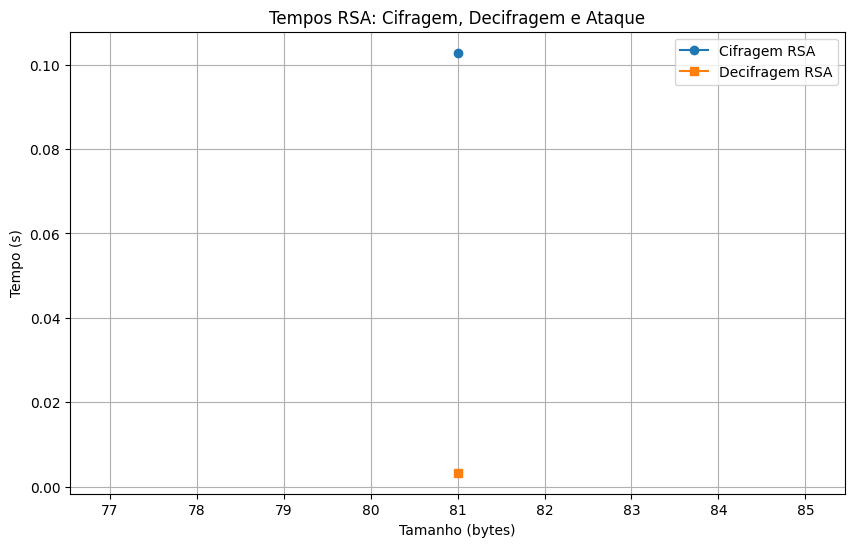

In [63]:
# plt.figure(figsize=(10, 6))

# tamanhos_ind = [dados['tamanho_bytes'] for dados in rsa_tempos_ind.values()]
# tempos_cifra_ind = [dados['tempo_cifra_s'] for dados in rsa_tempos_ind.values()]
# tempos_decifra_ind = [dados['tempo_decifra_s'] for dados in rsa_tempos_ind.values()]

# plt.plot(tamanhos_ind, tempos_cifra_ind, marker="o", label="RSA - Criptografia (Independente)")
# plt.plot(tamanhos_ind, tempos_decifra_ind, marker="s", label="RSA - Descriptografia (Independente)")

# plt.title("Tempo de Criptografia/Descriptografia RSA x Tamanho do Texto (Independente)")
# plt.xlabel("Tamanho (bytes)")
# plt.ylabel("Tempo (s)")
# plt.legend()
# plt.grid(True)
# plt.show()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

tamanhos = rsa_tempos_ind_df["tamanho_bytes"]
tempos_cifra = rsa_tempos_ind_df["tempo_cifra_s"]
tempos_decifra = rsa_tempos_ind_df["tempo_decifra_s"]
# tempos_ataque = rsa_tempos_ind_df["tempo_ataque_s"]

plt.plot(tamanhos, tempos_cifra, marker='o', label="Cifragem RSA")
plt.plot(tamanhos, tempos_decifra, marker='s', label="Decifragem RSA")
# plt.plot(tamanhos, tempos_ataque, marker='^', label="Ataque Franklin-Reiter")

plt.title("Tempos RSA: Cifragem, Decifragem e Ataque")
plt.xlabel("Tamanho (bytes)")
plt.ylabel("Tempo (s)")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
ic_rsa_ind_results = {}
for nome_texto, texto_original in textos.items():
    # Cifrar de forma independente para cada texto
    cifrado_independente = rsa_cifrar_independente(texto_original)
    ic_rsa_ind_results[nome_texto] = indice_coincidencia(cifrado_independente)

print("Índice de Coincidência dos textos cifrados por RSA (Independente):")
for texto, ic_val in ic_rsa_ind_results.items():
    print(f"  {texto}: {ic_val:.4f}")

ic_df_ind = pd.DataFrame(ic_rsa_ind_results.items(), columns=['Texto', 'IC Cifrado (RSA Independente)'])
display(ic_df_ind)

Índice de Coincidência dos textos cifrados por RSA (Independente):
  Curto1: 0.0000


,Texto,IC Cifrado (RSA Independente)
0,Curto1,0.0


In [65]:
expansao_rsa_ind_results = {}
for nome_texto, texto_original in textos.items():
    # Cifrar de forma independente para cada texto
    cifrado_independente = rsa_cifrar_independente(texto_original)
    original_size = len(texto_original.encode('utf-8'))
    ciphered_size = len(cifrado_independente)

    expansao_rsa_ind_results[nome_texto] = expansao_tamanho(original_size, ciphered_size)



print("Expansão de Tamanho dos textos cifrados por RSA (Independente):")
for texto, expansao_val in expansao_rsa_ind_results.items():
    print(f"  {texto}: {expansao_val:.2f}%")

expansao_df_ind = pd.DataFrame(expansao_rsa_ind_results.items(), columns=['Texto', 'Expansão (%) (RSA Independente)'])
display(expansao_df_ind)

Aviso: O expoente e=7 não é coprimo de phi. Gerando um novo...
Expansão de Tamanho dos textos cifrados por RSA (Independente):
  Curto1: 3.81%


,Texto,Expansão (%) (RSA Independente)
0,Curto1,3.814815


In [66]:
from typing import Callable


def bytes_from_output(out) -> bytes:
    """Converte qualquer saída comum de cifradores em bytes."""
    if isinstance(out, bytes):
        return out
    if isinstance(out, str):
        return out.encode('utf-8')
    if isinstance(out, int):
        length = (out.bit_length() + 7) // 8
        return out.to_bytes(length, 'big')
    if isinstance(out, list):
        return bytes(out)
    raise TypeError("Tipo de saída não suportado para cálculo de avalanche.")


def calcular_avalanche(func_encrypt: Callable, texto: str) -> float:
    """
    Mede avalanche com base na diferença de bits entre:
    - texto original
    - texto com 1 caractere alterado
    Retorna porcentagem de bits diferentes.
    """
    if len(texto) == 0:
        return 0.0

    # cifra original
    out1 = bytes_from_output(func_encrypt(texto))

    # cifra do texto alterado
    alterado = chr((ord(texto[0]) + 1) % 256) + texto[1:]
    out2 = bytes_from_output(func_encrypt(alterado))

    # iguala comprimentos com 0x00
    max_len = max(len(out1), len(out2))
    out1 = out1.ljust(max_len, b"\x00")
    out2 = out2.ljust(max_len, b"\x00")

    # conta bits diferentes
    dif_bits = 0
    total_bits = max_len * 8

    for b1, b2 in zip(out1, out2):
        dif_bits += bin(b1 ^ b2).count("1")

    return dif_bits / total_bits
